In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
credit = pd.read_csv('/content/drive/MyDrive/withoutDSA/woDSA.csv', usecols=list(range(0,17)))
credit

,age_attx,sex,do_age,do_sex,do_type2,CIT,INF,hla_mm_a,hla_mm_b,hla_mm_d,pre_ab2,bloodt_4,preg2,no_tx2,gfr_in,speed,gfr_365
0,28.34,1,61.0,1,2,2.21,2,1,1,0,2,2,0,2,91.23,-0.197095,52.762612
1,62.24,2,62.0,1,1,17.34,1,0,1,1,2,0,2,2,25.10,0.247069,42.670000
2,24.01,1,53.0,1,2,2.44,2,1,1,1,2,1,0,2,81.34,-0.370439,46.182825
3,69.05,1,44.0,1,1,21.03,2,1,1,0,2,2,0,2,55.61,-0.138711,29.519187
4,35.56,2,15.0,2,1,13.20,2,1,2,0,2,1,1,2,94.03,-0.396307,60.198615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,57.40,2,59.0,1,2,2.25,2,1,2,1,2,2,1,2,42.69,-0.168736,40.355530
358,47.56,1,50.0,1,1,13.39,2,0,0,0,2,2,0,2,51.54,-0.313864,32.870000
359,43.63,2,69.0,2,2,2.58,2,0,1,1,2,1,2,2,27.86,-0.079948,18.706012
360,60.55,2,60.0,1,1,22.50,2,1,1,0,2,2,1,2,35.12,-0.071551,32.060794


###**Best subset selection**

In [4]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

####**Forward stepwise selection**

In [6]:
#Initialization variables
Y = credit.gfr_365
X = credit.drop(columns = 'gfr_365', axis = 1)
k = 16

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [ ]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['gfr_in'], 71305),
 (2, ['gfr_in', 'speed'], 59734),
 (3, ['gfr_in', 'speed', 'do_age'], 57744),
 (4, ['gfr_in', 'speed', 'do_age', 'bloodt_4'], 56176)]

###**Combining forward stepwise results into a new DataFrame**

In [7]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [8]:
#Initializing useful variables
m = len(Y)
p = 17
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[gfr_in],71305.132864,0.589040,1,197.857963,1.238743,1.249493,0.587898
2,"[gfr_in, speed]",59733.997559,0.655729,2,166.775958,1.044146,1.065646,0.653811
3,"[gfr_in, speed, do_age]",57743.759834,0.667199,3,162.160521,1.015249,1.047501,0.664410
4,"[gfr_in, speed, do_age, bloodt_4]",56175.712348,0.676237,4,158.711356,0.993655,1.036657,0.672609
5,"[gfr_in, speed, do_age, bloodt_4, do_type2]",55861.714421,0.678046,5,158.726416,0.993749,1.047501,0.673524
6,"[gfr_in, speed, do_age, bloodt_4, do_type2, INF]",55550.749152,0.679839,6,158.749853,0.993896,1.058398,0.674427
7,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",55298.682393,0.681291,7,158.935994,0.995061,1.070314,0.674989
8,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",55158.750537,0.682098,8,159.431899,0.998166,1.084169,0.674893
9,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",55109.489119,0.682382,9,160.178275,1.002839,1.099593,0.674261
10,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",55062.149390,0.682655,10,160.929960,1.007545,1.115049,0.673613


In [9]:
df1['R_squared_adj'].idxmax()
df1['R_squared_adj'].max()

0.6749891304900041

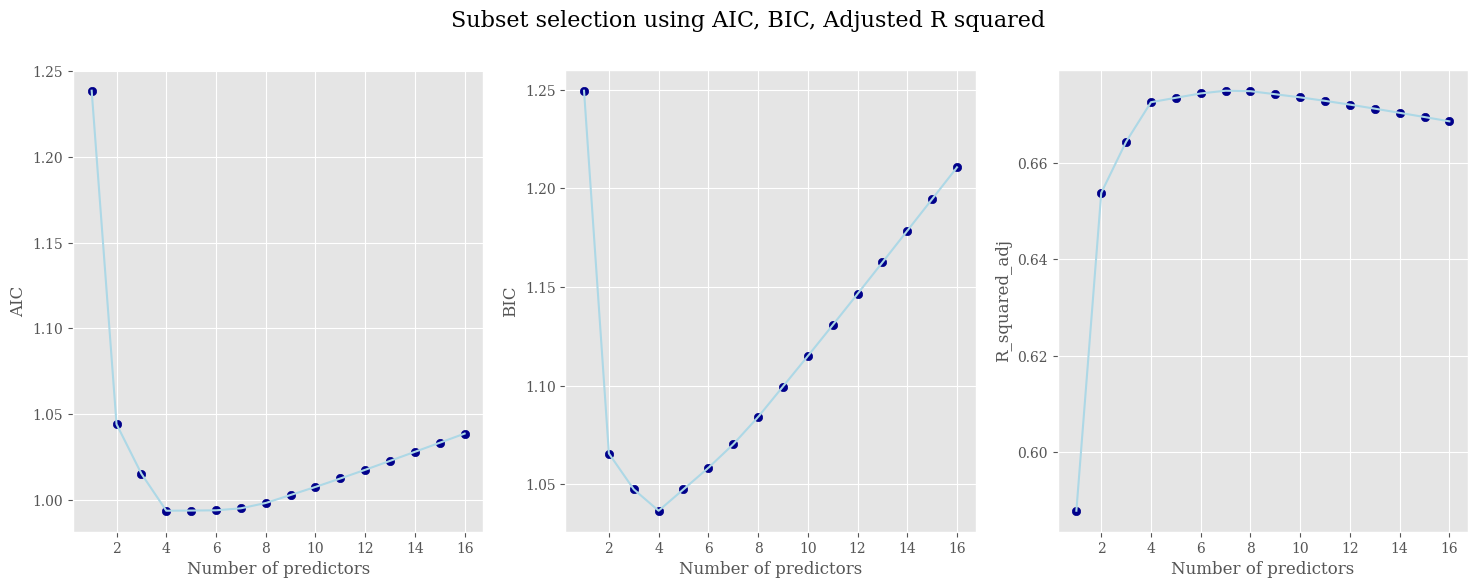

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#variables = ['C_p', 'AIC','BIC','R_squared_adj']
variables = ['AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
 #   if v == 'R_squared_adj':
 #       ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
 #   else:
 #       ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using AIC, BIC, Adjusted R squared', fontsize = 16)
plt.show()